In this notebook you will find:

Linear Regession Model using Microsoft Data
XGBoost Regressor Model using Microsoft Data



BUILDING A LINEAR REGRESSION MODEL ON MICROSOFT

In [1]:
# Initial imports
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time
import pandas_datareader.data as web

from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook
from dotenv import load_dotenv
%matplotlib inline
import alpaca_trade_api as tradeapi
from sklearn.model_selection import train_test_split


In [2]:
load_dotenv()

True

In [3]:
# Set alpaca api key and secret 
# Set Alpaca API key and secret
alpaca_api_key = "AKJOSY68C1QODKIRO118"
alpaca_secret_key ="2laEO7wv0FwL5VoldeijGFWG7IbKpO8AxYCknAzX"
# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2"
)

In [4]:
# Set the tickers
microsoft = ["MSFT"]
timeframe = "1D"

In [5]:
# Format start and end dates as ISO format for five year period
start = pd.Timestamp("2017-06-01", tz="America/New_York").isoformat()
end = pd.Timestamp("2022-06-01", tz="America/New_York").isoformat()

In [6]:
# Get closing prices for MSFT from the five years
df_microsoft_daily = alpaca.get_bars(
    microsoft,
    timeframe,
    start = start,
    end = end,
    limit = 10000
).df

# Display sample data
df_microsoft_daily

,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2017-06-01 04:00:00+00:00,70.24,70.61,69.4510,70.10,21922908,115317,69.906282,MSFT
2017-06-02 04:00:00+00:00,70.44,71.86,70.2400,71.76,35470261,152145,71.359913,MSFT
2017-06-05 04:00:00+00:00,71.97,72.89,71.8100,72.28,33317996,137660,72.420495,MSFT
2017-06-06 04:00:00+00:00,72.30,72.62,72.2700,72.52,31511065,140546,72.465401,MSFT
2017-06-07 04:00:00+00:00,72.67,72.77,71.9500,72.39,22302769,122842,72.316942,MSFT
...,...,...,...,...,...,...,...,...
2022-05-25 04:00:00+00:00,258.36,264.58,257.1250,262.52,28402776,337552,260.950089,MSFT
2022-05-26 04:00:00+00:00,262.29,267.11,261.4294,265.90,24933202,296973,265.279916,MSFT
2022-05-27 04:00:00+00:00,268.51,273.34,267.5600,273.24,26809462,306101,271.652696,MSFT


In [7]:
# Create a new df filtering the index and close columns
#microsoft_signals_df = df_microsoft_daily.loc[:, ["close"]]

# Create a column for the daily returns
df_microsoft_daily["Return Percentage"] = df_microsoft_daily["close"].pct_change() 

# Drop all NaN values from the DataFrame
df_microsoft_daily = df_microsoft_daily.dropna()

# Show signals df
display(df_microsoft_daily.head())
display(df_microsoft_daily.tail())

,open,high,low,close,volume,trade_count,vwap,symbol,Return Percentage
timestamp,,,,,,,,,
2017-06-02 04:00:00+00:00,70.44,71.86,70.24,71.76,35470261,152145,71.359913,MSFT,0.023680
2017-06-05 04:00:00+00:00,71.97,72.89,71.81,72.28,33317996,137660,72.420495,MSFT,0.007246
2017-06-06 04:00:00+00:00,72.30,72.62,72.27,72.52,31511065,140546,72.465401,MSFT,0.003320
2017-06-07 04:00:00+00:00,72.67,72.77,71.95,72.39,22302769,122842,72.316942,MSFT,-0.001793
2017-06-08 04:00:00+00:00,72.42,72.52,71.50,71.95,26179442,136478,71.981665,MSFT,-0.006078


,open,high,low,close,volume,trade_count,vwap,symbol,Return Percentage
timestamp,,,,,,,,,
2022-05-25 04:00:00+00:00,258.36,264.58,257.1250,262.52,28402776,337552,260.950089,MSFT,0.011170
2022-05-26 04:00:00+00:00,262.29,267.11,261.4294,265.90,24933202,296973,265.279916,MSFT,0.012875
2022-05-27 04:00:00+00:00,268.51,273.34,267.5600,273.24,26809462,306101,271.652696,MSFT,0.027604
2022-05-31 04:00:00+00:00,272.50,274.77,268.9300,271.87,37691020,361137,271.999157,MSFT,-0.005014
2022-06-01 04:00:00+00:00,275.00,277.69,270.0400,272.42,25108530,318649,273.328471,MSFT,0.002023


In [8]:
new_df = df_microsoft_daily.loc[:, ['open', 'high', 'low', 'close', 'vwap', 'symbol', 'Return Percentage']]
new_df


# EWMA indicators
short_span = 9
long_span = 20


new_df['9EWMA'] = df_microsoft_daily.loc[:, 'close'].ewm(span= short_span).mean()
new_df['20EWMA'] = df_microsoft_daily.loc[:, 'close'].ewm(span= long_span).mean()
new_df

,open,high,low,close,vwap,symbol,Return Percentage,9EWMA,20EWMA
timestamp,,,,,,,,,
2017-06-02 04:00:00+00:00,70.44,71.86,70.2400,71.76,71.359913,MSFT,0.023680,71.760000,71.760000
2017-06-05 04:00:00+00:00,71.97,72.89,71.8100,72.28,72.420495,MSFT,0.007246,72.048889,72.033000
2017-06-06 04:00:00+00:00,72.30,72.62,72.2700,72.52,72.465401,MSFT,0.003320,72.241967,72.211823
2017-06-07 04:00:00+00:00,72.67,72.77,71.9500,72.39,72.316942,MSFT,-0.001793,72.292114,72.263260
2017-06-08 04:00:00+00:00,72.42,72.52,71.5000,71.95,71.981665,MSFT,-0.006078,72.190343,72.187485
...,...,...,...,...,...,...,...,...,...
2022-05-25 04:00:00+00:00,258.36,264.58,257.1250,262.52,260.950089,MSFT,0.011170,260.540791,266.336119
2022-05-26 04:00:00+00:00,262.29,267.11,261.4294,265.90,265.279916,MSFT,0.012875,261.612633,266.294584
2022-05-27 04:00:00+00:00,268.51,273.34,267.5600,273.24,271.652696,MSFT,0.027604,263.938106,266.956052


In [9]:
# Create column "Signal" such that if 8EWMA is gerater than 20EWMA then set sugnal to 1, else 
new_df['Signal'] = 0.0
new_df['Signal'] = np.where(new_df['9EWMA'] > new_df['20EWMA'], 1.0, 0.0)

new_df

,open,high,low,close,vwap,symbol,Return Percentage,9EWMA,20EWMA,Signal
timestamp,,,,,,,,,,
2017-06-02 04:00:00+00:00,70.44,71.86,70.2400,71.76,71.359913,MSFT,0.023680,71.760000,71.760000,0.0
2017-06-05 04:00:00+00:00,71.97,72.89,71.8100,72.28,72.420495,MSFT,0.007246,72.048889,72.033000,1.0
2017-06-06 04:00:00+00:00,72.30,72.62,72.2700,72.52,72.465401,MSFT,0.003320,72.241967,72.211823,1.0
2017-06-07 04:00:00+00:00,72.67,72.77,71.9500,72.39,72.316942,MSFT,-0.001793,72.292114,72.263260,1.0
2017-06-08 04:00:00+00:00,72.42,72.52,71.5000,71.95,71.981665,MSFT,-0.006078,72.190343,72.187485,1.0
...,...,...,...,...,...,...,...,...,...,...
2022-05-25 04:00:00+00:00,258.36,264.58,257.1250,262.52,260.950089,MSFT,0.011170,260.540791,266.336119,0.0
2022-05-26 04:00:00+00:00,262.29,267.11,261.4294,265.90,265.279916,MSFT,0.012875,261.612633,266.294584,0.0
2022-05-27 04:00:00+00:00,268.51,273.34,267.5600,273.24,271.652696,MSFT,0.027604,263.938106,266.956052,0.0


In [10]:
#Reimport the libraries
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_datareader.data as web
import time

from datetime import *
from matplotlib import pyplot as plt

from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import *
from tqdm import tqdm_notebook
from xgboost import XGBRegressor
%matplotlib inline

In [11]:
test_size = 0.2                 # proportion of dataset to be used as test set
cv_size = 0.2                   # proportion of dataset to be used as cross-validation set
Nmax = 30                       # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
                                # Nmax is the maximum N we are going to test
fontsize = 14
ticklabelsize = 14

In [12]:
def get_preds_lin_reg(df, target_col, N, pred_min, offset):

    regr = LinearRegression(fit_intercept=True)

    pred_list = []
    
    for i in range(offset, len(df['close'])):
        X_train = np.array(range(len(df['close'][i-N:i]))) 
        y_train = np.array(df['close'][i-N:i]) 
        X_train = X_train.reshape(-1, 1)     
              
        y_train = y_train.reshape(-1, 1)
    #     print X_train.shape
    #     print y_train.shape
    #     print 'X_train = \n' + str(X_train)
    #     print 'y_train = \n' + str(y_train)
        regr.fit(X_train, y_train)            
        pred = regr.predict(np.array(N).reshape(1,-1))
    
        pred_list.append(pred[0][0])  
    
    # If the values are < pred_min, set it to be pred_min
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min

    return pred_list

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [13]:
new_df.columns

Index(['open', 'high', 'low', 'close', 'vwap', 'symbol', 'Return Percentage',
       '9EWMA', '20EWMA', 'Signal'],
      dtype='object')

In [14]:
new_df['date']=new_df.index
new_df['date'] = pd.to_datetime(new_df['date'],format='%Y-%m-%d')
start = datetime(2017, 1, 6)
end = datetime(2022, 1,6)

In [15]:
new_df=new_df.reset_index(drop=True)
new_df.head()
new_df["date"] = pd.to_datetime(new_df["date"]).dt.date
new_df

,open,high,low,close,vwap,symbol,Return Percentage,9EWMA,20EWMA,Signal,date
0,70.44,71.86,70.2400,71.76,71.359913,MSFT,0.023680,71.760000,71.760000,0.0,2017-06-02
1,71.97,72.89,71.8100,72.28,72.420495,MSFT,0.007246,72.048889,72.033000,1.0,2017-06-05
2,72.30,72.62,72.2700,72.52,72.465401,MSFT,0.003320,72.241967,72.211823,1.0,2017-06-06
3,72.67,72.77,71.9500,72.39,72.316942,MSFT,-0.001793,72.292114,72.263260,1.0,2017-06-07
4,72.42,72.52,71.5000,71.95,71.981665,MSFT,-0.006078,72.190343,72.187485,1.0,2017-06-08
...,...,...,...,...,...,...,...,...,...,...,...
1254,258.36,264.58,257.1250,262.52,260.950089,MSFT,0.011170,260.540791,266.336119,0.0,2022-05-25
1255,262.29,267.11,261.4294,265.90,265.279916,MSFT,0.012875,261.612633,266.294584,0.0,2022-05-26
1256,268.51,273.34,267.5600,273.24,271.652696,MSFT,0.027604,263.938106,266.956052,0.0,2022-05-27
1257,272.50,274.77,268.9300,271.87,271.999157,MSFT,-0.005014,265.524485,267.424047,0.0,2022-05-31


In [16]:
new_df.columns

Index(['open', 'high', 'low', 'close', 'vwap', 'symbol', 'Return Percentage',
       '9EWMA', '20EWMA', 'Signal', 'date'],
      dtype='object')

Text(0.5, 0, 'date')

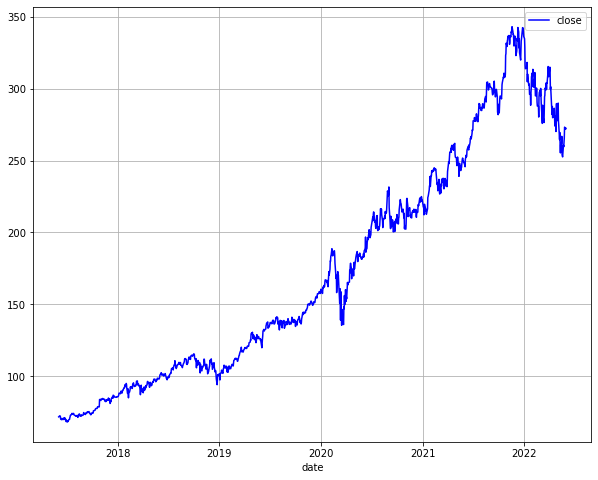

In [17]:
#Plot the close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = new_df.plot(x='date', y='close', style='b-', grid=True)
ax.set_xlabel("date")

In [18]:
#build the sizes of each dataset that will be used
num_cv = int(cv_size*len(new_df))
num_test = int(test_size*len(new_df))
num_train = len(new_df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = new_df[:num_train].copy()
cv = new_df[num_train:num_train+num_cv].copy()
train_cv = new_df[:num_train+num_cv].copy()
test = new_df[num_train+num_cv:].copy()
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 757
num_cv = 251
num_test = 251
train.shape = (757, 11)
cv.shape = (251, 11)
train_cv.shape = (1008, 11)
test.shape = (251, 11)


Text(0, 0.5, 'USD')

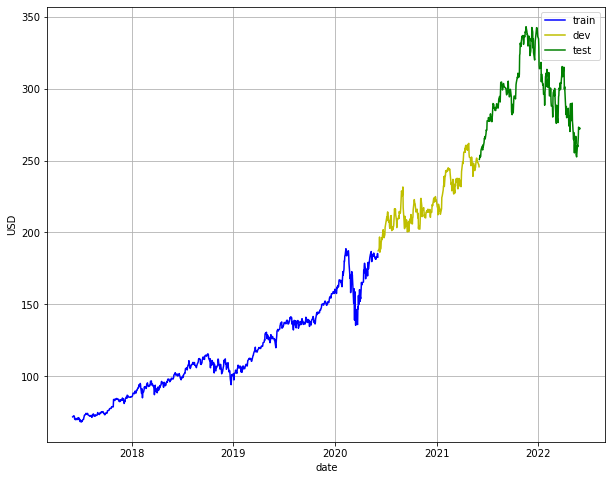

In [19]:
# Plot the dataset of train, dev, and test over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [20]:
#get the Root Mean Square Error and the Mean absolute percentage error
RMSE = []
R2 = []
mape = []
for N in range(1, Nmax+1): # N is no. of samples to use to predict the next value
    est_list = get_preds_lin_reg(train_cv, 'close', N, 0, num_train)
    
    cv.loc[:, 'est' + '_N' + str(N)] = est_list
    RMSE.append(math.sqrt(mean_squared_error(est_list, cv['close'])))
    R2.append(r2_score(cv['close'], est_list))
    mape.append(get_mape(cv['close'], est_list))
print('RMSE = ' + str(RMSE))
print('R2 = ' + str(R2))
print('MAPE = ' + str(mape))
cv.head()

RMSE = [3.830017371726802, 5.752355173304294, 4.748792940921969, 4.624388405777573, 4.53090631813824, 4.615742895674866, 4.792873376807935, 4.991908045388306, 5.098999586088792, 5.161258449510854, 5.256229593403715, 5.348805332349159, 5.479251145844567, 5.6425506406758075, 5.8305643351455245, 6.033360042331171, 6.218961605010544, 6.401514189285648, 6.548801852917421, 6.679393099278694, 6.786949582060921, 6.873382254349307, 6.9565968851577855, 7.039554408961912, 7.127242149779509, 7.224540529669156, 7.34527916635775, 7.4667434862490385, 7.589102456609606, 7.699666200377615]
R2 = [0.954866260315075, 0.8981898168581703, 0.9306148870655487, 0.9342026444292437, 0.9368359457934496, 0.934448436912503, 0.929320780807925, 0.9233286720027528, 0.9200037211544028, 0.9180382833593348, 0.9149942142236076, 0.9119735036027727, 0.9076275959868672, 0.9020395518955954, 0.8954025695664918, 0.8879999239441312, 0.8810031176617137, 0.8739144674664797, 0.8680457044550487, 0.862730567178996, 0.8582741474741494

,open,high,low,close,vwap,symbol,Return Percentage,9EWMA,20EWMA,Signal,...,est_N21,est_N22,est_N23,est_N24,est_N25,est_N26,est_N27,est_N28,est_N29,est_N30
757,182.47,187.73,182.0100,187.20,185.920358,MSFT,0.023398,184.176476,182.459116,1.0,...,183.330714,183.553636,183.894585,184.517464,184.6384,184.861323,185.595128,185.881429,186.065320,186.407310
758,185.61,188.55,184.4400,188.36,186.742662,MSFT,0.006197,185.013181,183.021105,1.0,...,183.998905,184.039610,184.222253,184.522572,185.0985,185.198277,185.398348,186.093571,186.362094,186.533793
759,188.07,190.70,187.2605,189.80,189.309536,MSFT,0.007645,185.970545,183.666714,1.0,...,184.937571,184.837792,184.842253,184.985978,185.2467,185.776862,185.854359,186.030556,186.687217,186.936368
760,191.10,198.52,191.0100,196.84,195.313660,MSFT,0.037092,188.144436,184.921312,1.0,...,186.200810,185.932338,185.798458,185.766775,185.8717,186.092769,186.577350,186.630794,186.781478,187.398920
761,193.13,195.76,186.0700,186.27,190.169706,MSFT,-0.053698,187.769549,185.049759,1.0,...,188.957476,188.338571,187.997668,187.790326,187.6863,187.719046,187.869430,188.279841,188.280887,188.379609


Text(0, 0.5, 'RMSE')

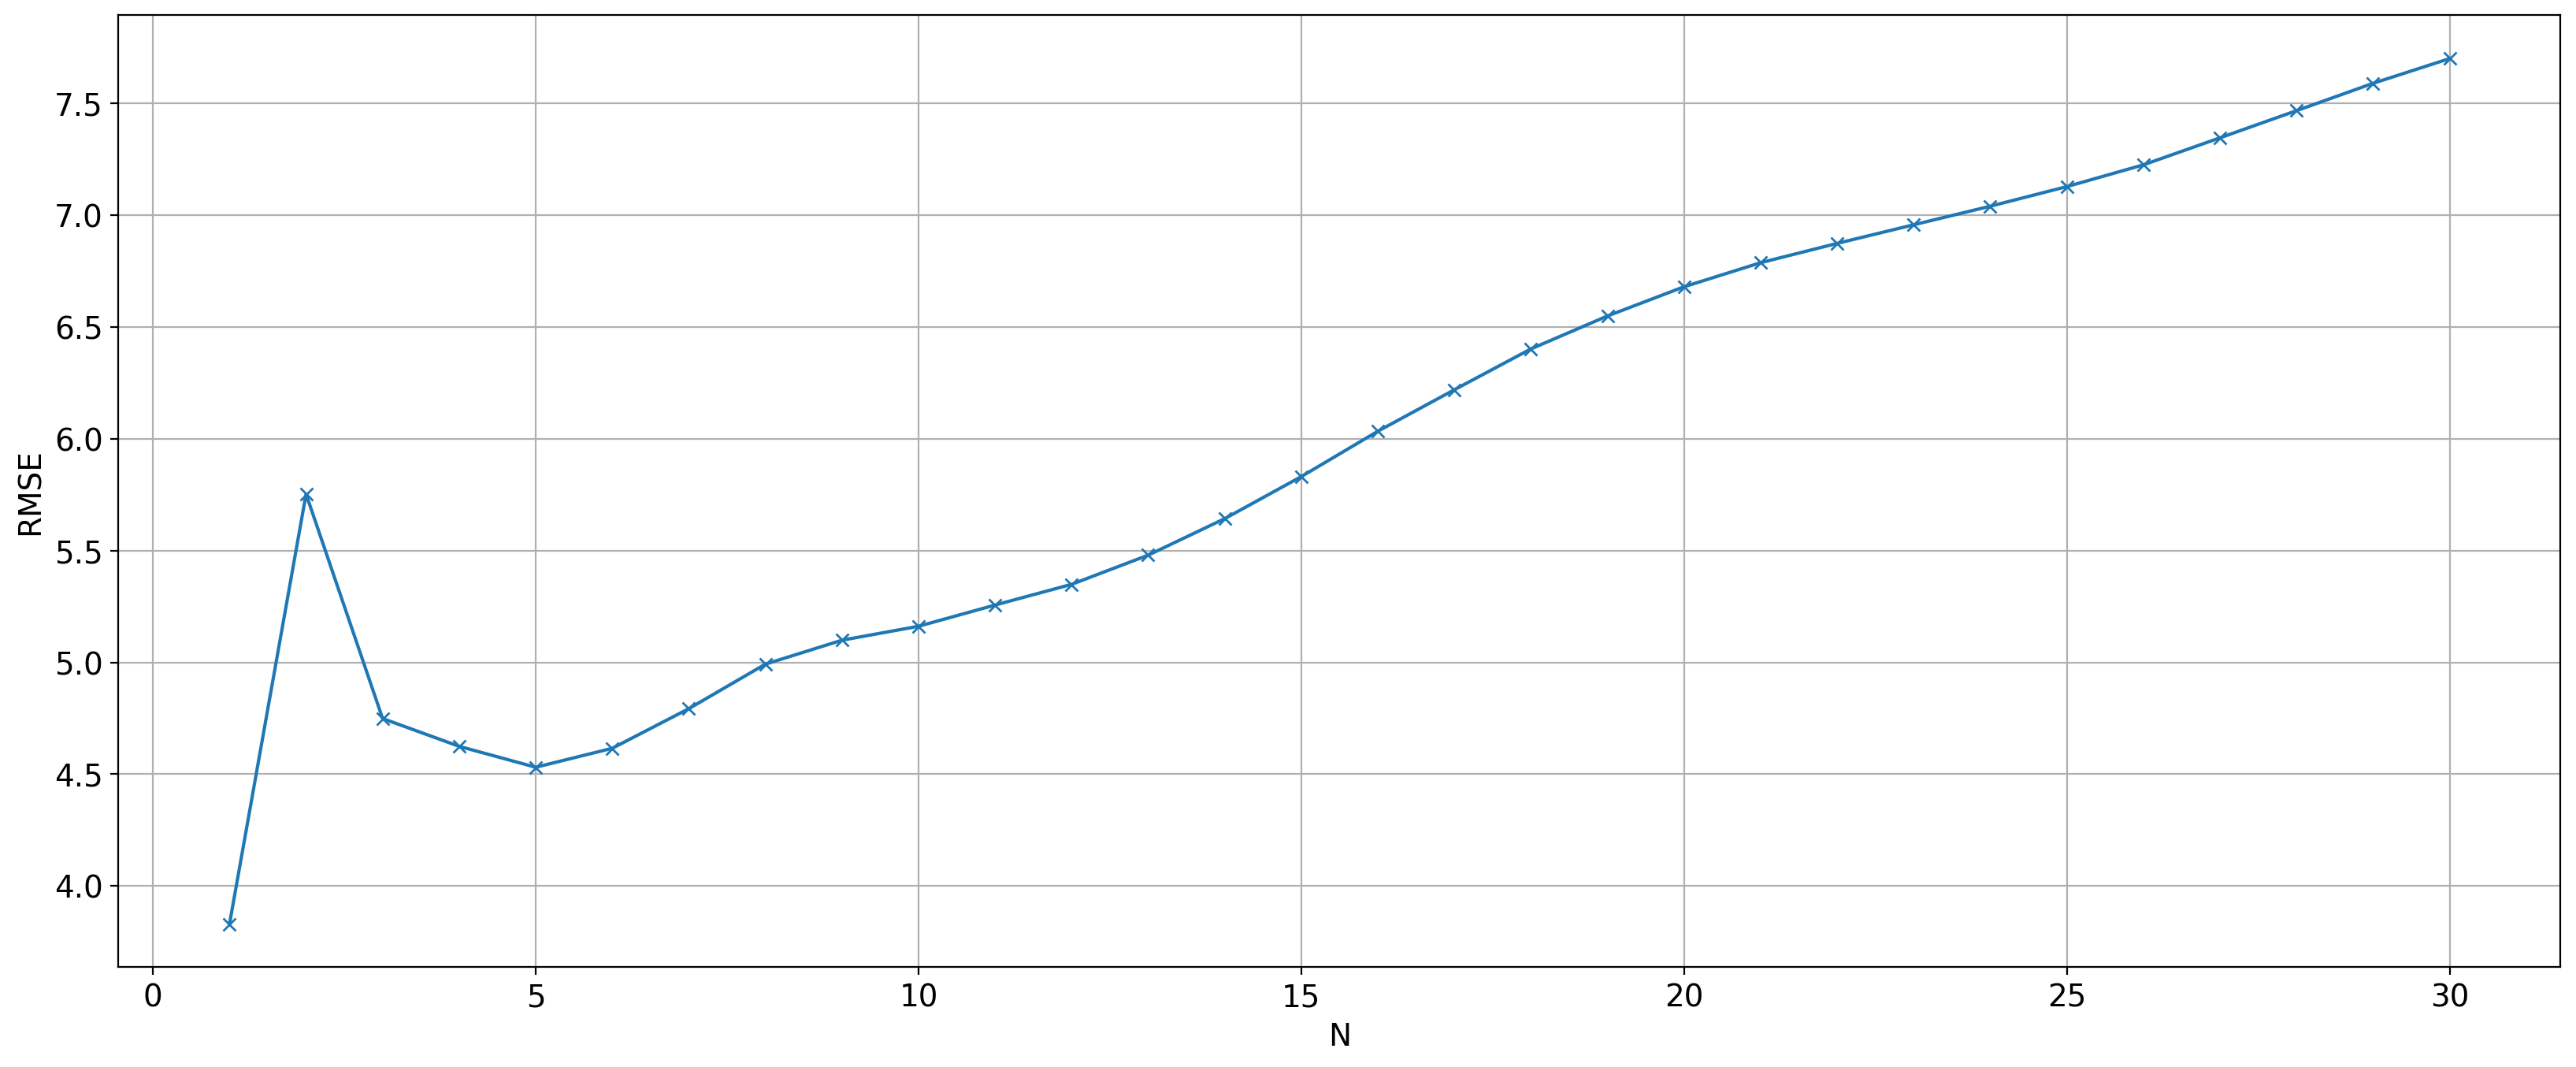

In [21]:
# Plot RMSE versus N
matplotlib.rcParams.update({'font.size': 14})
plt.figure(figsize=(20, 8), dpi=200)
plt.plot(range(1, Nmax+1), RMSE, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('RMSE')
#plt.xlim([2, 30])

Plot Prediction on the dev set of data

Text(0, 0.5, 'USD')

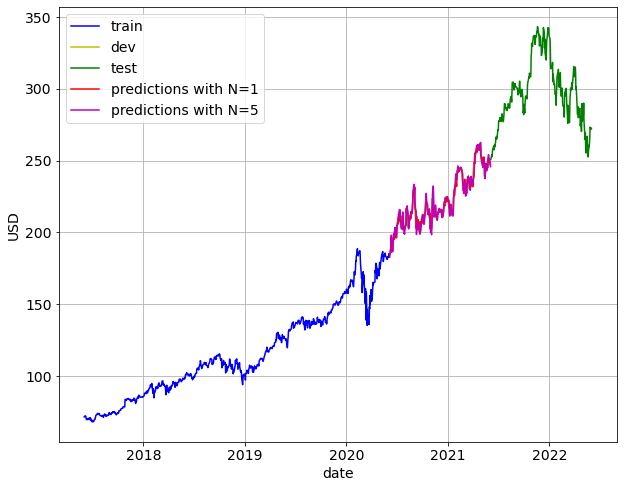

In [22]:
# Plot predictions on the dev set of data
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='r-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N5', style='m-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N=1', 'predictions with N=5'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

A quick view of the of the dev set of data

Text(0.5, 1.0, 'Zoom in to dev set')

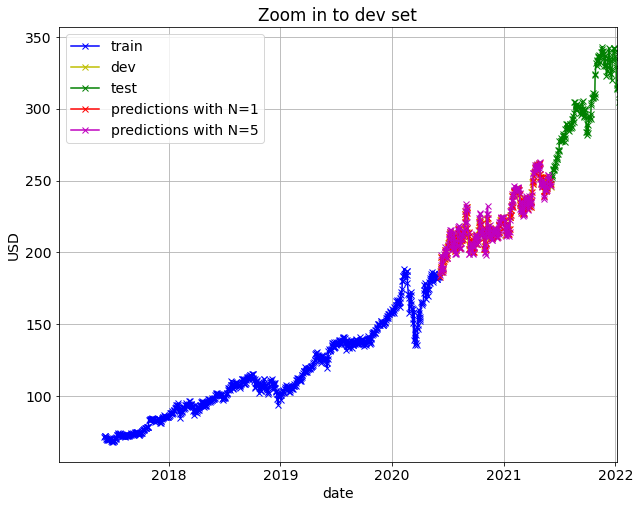

In [23]:
# Plot close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='close', style='bx-', grid=True)
ax = cv.plot(x='date', y='close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='gx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='rx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N5', style='mx-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N=1', 'predictions with N=5'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2017, 1, 6), date(2022, 1, 6)])
#ax.set_ylim([127, 137])
ax.set_title('Zoom in to dev set')

Here you will see our final Linear Regression Model

In [24]:
N_opt = 5
est_list = get_preds_lin_reg(new_df, 'close', N_opt, 0, num_train+num_cv)
test.loc[:, 'est' + '_N' + str(N_opt)] = est_list
print("RMSE = %0.3f" % math.sqrt(mean_squared_error(est_list, test['close'])))
print("R2 = %0.3f" % r2_score(test['close'], est_list))
print("MAPE = %0.3f%%" % get_mape(test['close'], est_list))
test.head()

RMSE = 6.077
R2 = 0.931
MAPE = 1.590%


,open,high,low,close,vwap,symbol,Return Percentage,9EWMA,20EWMA,Signal,date,est_N5
1008,247.88,251.65,247.51,250.79,250.214451,MSFT,0.020675,248.366611,248.418978,0.0,2021-06-04,245.006
1009,249.95,254.09,249.81,253.81,252.662218,MSFT,0.012042,249.455289,248.932409,1.0,2021-06-07,248.335
1010,255.25,256.01,252.51,252.57,253.568635,MSFT,-0.004886,250.078231,249.278846,1.0,2021-06-08,253.895
1011,254.01,255.53,253.21,253.59,254.211167,MSFT,0.004038,250.780585,249.689432,1.0,2021-06-09,255.628
1012,254.00,257.46,253.67,257.24,256.427341,MSFT,0.014393,252.072468,250.408534,1.0,2021-06-10,256.556


Text(0, 0.5, 'USD')

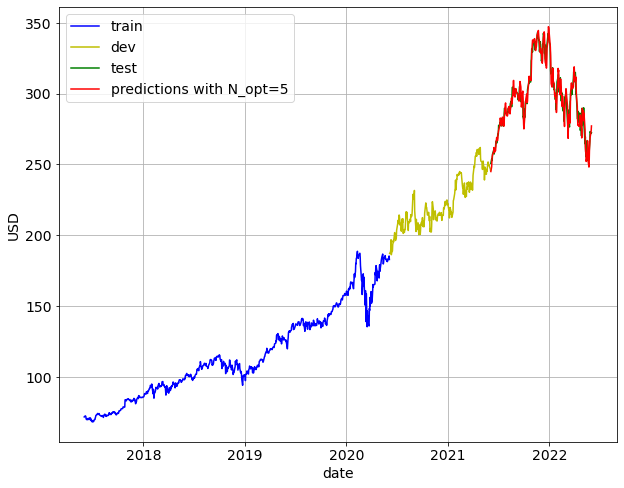

In [25]:
#Using test data on the model
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N5', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N_opt=5'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to test set')

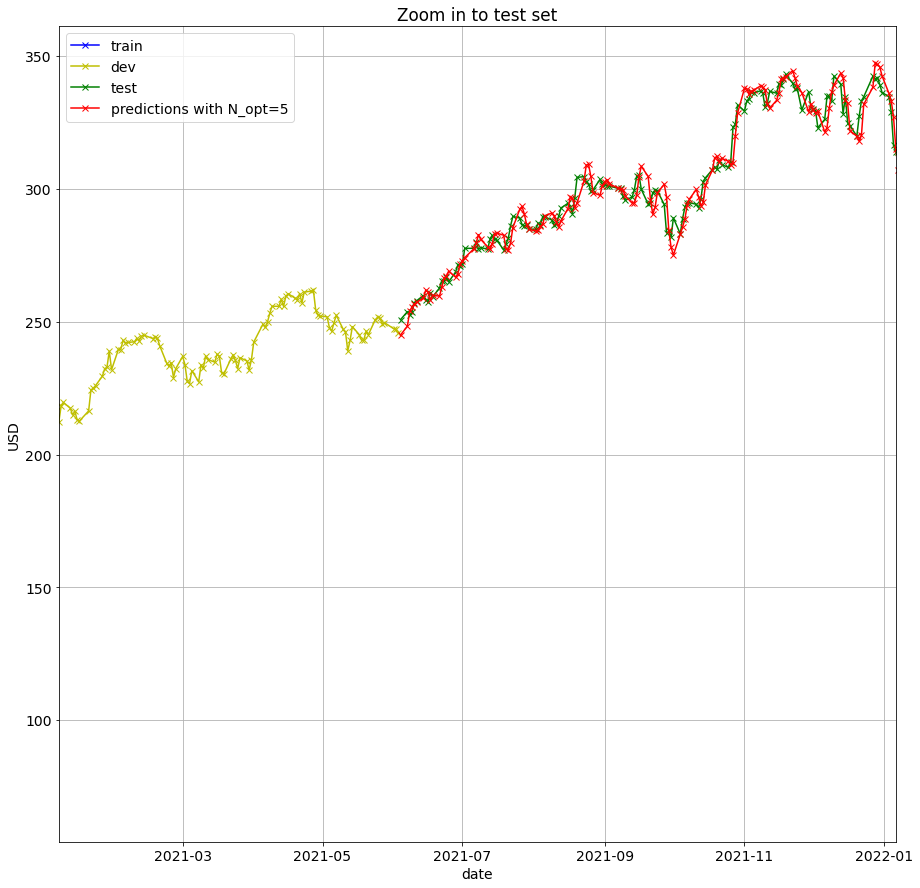

In [26]:
# Plot close over time on test data
rcParams['figure.figsize'] = 15, 15 # width 10, height 8

ax = train.plot(x='date', y='close', style='bx-', grid=True)
ax = cv.plot(x='date', y='close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='gx-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N5', style='rx-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N_opt=5'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2021,1,6), date(2022, 1, 6)])
#ax.set_ylim([135, 150])
ax.set_title('Zoom in to test set')

BUILDING XGBOOST REGRESSION MODEL ON MICROSOFT DATA

In [27]:
#Import Libraries 
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_datareader.data as web
import time

from datetime import *
from matplotlib import pyplot as plt

from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import *
from tqdm import tqdm_notebook
from xgboost import XGBRegressor
%matplotlib inline


In [28]:
test_size = 0.2                                                # proportion of dataset to be used as test set
cv_size = 0.2                                                   # proportion of dataset to be used as cross-validation set
N = 3                                                              # for feature at day t, we use lags from t-1, t-2, ..., t-N as features


model_seed = 100

fontsize = 14
ticklabelsize = 14

Functions that will be used later

In [29]:
def get_mov_avg_std(new_df, col, N):
    
    mean_list = new_df[col].rolling(window = N, min_periods=1).mean() 
    std_list = new_df[col].rolling(window = N, min_periods=1).std()   
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))

     # Append mean_list to df
    df_out = new_df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out


In [30]:
def scale_row(row, feat_mean, feat_std):
 # set it to a small number to avoid division by zero
    feat_std = 0.001 if feat_std == 0 else feat_std
    
    row_scaled = (row-feat_mean) / feat_std
    return row_scaled

In [31]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Text(0, 0.5, 'USD')

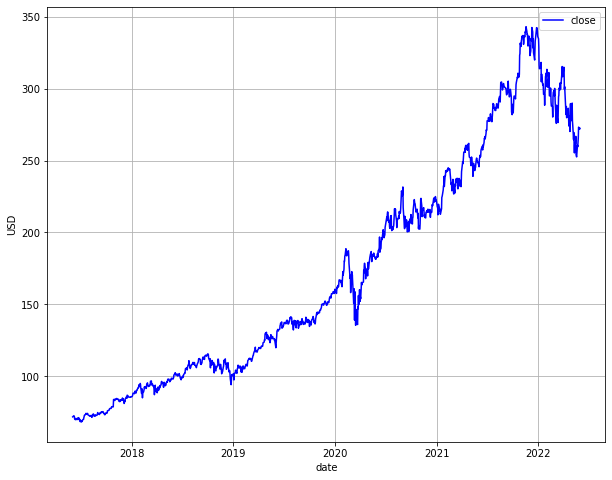

In [32]:
#Display the closing price over time
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = new_df.plot(x='date', y='close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [33]:
#get the difference of the hl and oc of each day
# Get difference between high and low of each day
new_df['range_hl'] = new_df['high'] - new_df['low']
new_df.drop(['high', 'low'], axis=1, inplace=True)

# Get difference between open and close of each day
new_df['range_oc'] = new_df['open'] - new_df['close']
new_df.drop(['open'], axis=1, inplace=True)

new_df.head()

,close,vwap,symbol,Return Percentage,9EWMA,20EWMA,Signal,date,range_hl,range_oc
0,71.76,71.359913,MSFT,0.023680,71.760000,71.760000,0.0,2017-06-02,1.62,-1.32
1,72.28,72.420495,MSFT,0.007246,72.048889,72.033000,1.0,2017-06-05,1.08,-0.31
2,72.52,72.465401,MSFT,0.003320,72.241967,72.211823,1.0,2017-06-06,0.35,-0.22
3,72.39,72.316942,MSFT,-0.001793,72.292114,72.263260,1.0,2017-06-07,0.82,0.28
4,71.95,71.981665,MSFT,-0.006078,72.190343,72.187485,1.0,2017-06-08,1.02,0.47


In [34]:
# Add a column 'order_day' to indicate the order of the rows by date
new_df['order_day'] = [x for x in list(range(len(new_df)))]
print(new_df.head())

# merging_keys
merging_keys = ['order_day']

# List of columns that we will use to create lags
lag_cols = ['close', 'range_hl', 'range_oc', 'vwap']
lag_cols

   close       vwap symbol  Return Percentage      9EWMA     20EWMA  Signal  \
0  71.76  71.359913   MSFT           0.023680  71.760000  71.760000     0.0   
1  72.28  72.420495   MSFT           0.007246  72.048889  72.033000     1.0   
2  72.52  72.465401   MSFT           0.003320  72.241967  72.211823     1.0   
3  72.39  72.316942   MSFT          -0.001793  72.292114  72.263260     1.0   
4  71.95  71.981665   MSFT          -0.006078  72.190343  72.187485     1.0   

         date  range_hl  range_oc  order_day  
0  2017-06-02      1.62     -1.32          0  
1  2017-06-05      1.08     -0.31          1  
2  2017-06-06      0.35     -0.22          2  
3  2017-06-07      0.82      0.28          3  
4  2017-06-08      1.02      0.47          4  


['close', 'range_hl', 'range_oc', 'vwap']

In [35]:
shift_range = [x+1 for x in range(N)]

for shift in tqdm_notebook(shift_range):
    train_shift = new_df[merging_keys + lag_cols].copy()
    
    # E.g. order_day of 0 becomes 1, for shift = 1.
    # So when this is merged with order_day of 1 in df, this will represent lag of 1.
    train_shift['order_day'] = train_shift['order_day'] + shift
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    new_df = pd.merge(new_df, train_shift, on=merging_keys, how='left') #.fillna(0)

      
print(train_shift.head())
    
del train_shift

# Remove the first N rows which contain NaNs
new_df = new_df[N:]
    
new_df.head()  

C:\Users\tempe\AppData\Local\Temp\ipykernel_37268\1829314114.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for shift in tqdm_notebook(shift_range):


  0%|          | 0/3 [00:00<?, ?it/s]

   order_day  close_lag_3  range_hl_lag_3  range_oc_lag_3  vwap_lag_3
0          3        71.76            1.62           -1.32   71.359913
1          4        72.28            1.08           -0.31   72.420495
2          5        72.52            0.35           -0.22   72.465401
3          6        72.39            0.82            0.28   72.316942
4          7        71.95            1.02            0.47   71.981665


,close,vwap,symbol,Return Percentage,9EWMA,20EWMA,Signal,date,range_hl,range_oc,...,range_oc_lag_1,vwap_lag_1,close_lag_2,range_hl_lag_2,range_oc_lag_2,vwap_lag_2,close_lag_3,range_hl_lag_3,range_oc_lag_3,vwap_lag_3
3,72.39,72.316942,MSFT,-0.001793,72.292114,72.263260,1.0,2017-06-07,0.82,0.28,...,-0.22,72.465401,72.28,1.08,-0.31,72.420495,71.76,1.62,-1.32,71.359913
4,71.95,71.981665,MSFT,-0.006078,72.190343,72.187485,1.0,2017-06-08,1.02,0.47,...,0.28,72.316942,72.52,0.35,-0.22,72.465401,72.28,1.08,-0.31,72.420495
5,70.32,70.282896,MSFT,-0.022655,71.683376,71.793531,0.0,2017-06-09,3.49,1.70,...,0.47,71.981665,72.39,0.82,0.28,72.316942,72.52,0.35,-0.22,72.465401
6,69.78,69.223695,MSFT,-0.007679,71.201682,71.412822,0.0,2017-06-12,1.81,-0.49,...,1.70,70.282896,71.95,1.02,0.47,71.981665,72.39,0.82,0.28,72.316942
7,70.65,70.528400,MSFT,0.012468,71.069103,71.280965,0.0,2017-06-13,0.86,-0.61,...,-0.49,69.223695,70.32,3.49,1.70,70.282896,71.95,1.02,0.47,71.981665


In [36]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1256 entries, 3 to 1258
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   close              1256 non-null   float64
 1   vwap               1256 non-null   float64
 2   symbol             1256 non-null   object 
 3   Return Percentage  1256 non-null   float64
 4   9EWMA              1256 non-null   float64
 5   20EWMA             1256 non-null   float64
 6   Signal             1256 non-null   float64
 7   date               1256 non-null   object 
 8   range_hl           1256 non-null   float64
 9   range_oc           1256 non-null   float64
 10  order_day          1256 non-null   int64  
 11  close_lag_1        1256 non-null   float64
 12  range_hl_lag_1     1256 non-null   float64
 13  range_oc_lag_1     1256 non-null   float64
 14  vwap_lag_1         1256 non-null   float64
 15  close_lag_2        1256 non-null   float64
 16  range_hl_lag_2     1256 

In [37]:
# # Get mean of close of each month
group_df= new_df.groupby(['date'], as_index=False).agg({'close':'mean'})
group_df
group_df = new_df.rename(columns={'close':'close_mean'})
group_df


,close_mean,vwap,symbol,Return Percentage,9EWMA,20EWMA,Signal,date,range_hl,range_oc,...,range_oc_lag_1,vwap_lag_1,close_lag_2,range_hl_lag_2,range_oc_lag_2,vwap_lag_2,close_lag_3,range_hl_lag_3,range_oc_lag_3,vwap_lag_3
3,72.39,72.316942,MSFT,-0.001793,72.292114,72.263260,1.0,2017-06-07,0.8200,0.28,...,-0.22,72.465401,72.28,1.0800,-0.31,72.420495,71.76,1.6200,-1.32,71.359913
4,71.95,71.981665,MSFT,-0.006078,72.190343,72.187485,1.0,2017-06-08,1.0200,0.47,...,0.28,72.316942,72.52,0.3500,-0.22,72.465401,72.28,1.0800,-0.31,72.420495
5,70.32,70.282896,MSFT,-0.022655,71.683376,71.793531,0.0,2017-06-09,3.4900,1.70,...,0.47,71.981665,72.39,0.8200,0.28,72.316942,72.52,0.3500,-0.22,72.465401
6,69.78,69.223695,MSFT,-0.007679,71.201682,71.412822,0.0,2017-06-12,1.8100,-0.49,...,1.70,70.282896,71.95,1.0200,0.47,71.981665,72.39,0.8200,0.28,72.316942
7,70.65,70.528400,MSFT,0.012468,71.069103,71.280965,0.0,2017-06-13,0.8600,-0.61,...,-0.49,69.223695,70.32,3.4900,1.70,70.282896,71.95,1.0200,0.47,71.981665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,262.52,260.950089,MSFT,0.011170,260.540791,266.336119,0.0,2022-05-25,7.4550,-4.16,...,-1.72,257.873654,260.65,8.0700,-4.89,258.921769,252.56,12.1000,4.41,251.563628
1255,265.90,265.279916,MSFT,0.012875,261.612633,266.294584,0.0,2022-05-26,5.6806,-3.61,...,-4.16,260.950089,259.62,7.8300,-1.72,257.873654,260.65,8.0700,-4.89,258.921769
1256,273.24,271.652696,MSFT,0.027604,263.938106,266.956052,0.0,2022-05-27,5.7800,-4.73,...,-3.61,265.279916,262.52,7.4550,-4.16,260.950089,259.62,7.8300,-1.72,257.873654
1257,271.87,271.999157,MSFT,-0.005014,265.524485,267.424047,0.0,2022-05-31,5.8400,0.63,...,-4.73,271.652696,265.90,5.6806,-3.61,265.279916,262.52,7.4550,-4.16,260.950089


In [38]:
group_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1256 entries, 3 to 1258
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   close_mean         1256 non-null   float64
 1   vwap               1256 non-null   float64
 2   symbol             1256 non-null   object 
 3   Return Percentage  1256 non-null   float64
 4   9EWMA              1256 non-null   float64
 5   20EWMA             1256 non-null   float64
 6   Signal             1256 non-null   float64
 7   date               1256 non-null   object 
 8   range_hl           1256 non-null   float64
 9   range_oc           1256 non-null   float64
 10  order_day          1256 non-null   int64  
 11  close_lag_1        1256 non-null   float64
 12  range_hl_lag_1     1256 non-null   float64
 13  range_oc_lag_1     1256 non-null   float64
 14  vwap_lag_1         1256 non-null   float64
 15  close_lag_2        1256 non-null   float64
 16  range_hl_lag_2     1256 

In [39]:
# # Get mean of vwap of each month
group_df = new_df.groupby(['date'], as_index=False).agg({'vwap':'mean'})
group_df = group_df.rename(columns={'vwap':'vwap_mean'})
group_df

# # Merge to main df
new_df = new_df.merge(group_df, 
              left_on=['date'], 
               right_on=['date'],
               how='left').fillna(0)

new_df.head()

,close,vwap,symbol,Return Percentage,9EWMA,20EWMA,Signal,date,range_hl,range_oc,...,vwap_lag_1,close_lag_2,range_hl_lag_2,range_oc_lag_2,vwap_lag_2,close_lag_3,range_hl_lag_3,range_oc_lag_3,vwap_lag_3,vwap_mean
0,72.39,72.316942,MSFT,-0.001793,72.292114,72.263260,1.0,2017-06-07,0.82,0.28,...,72.465401,72.28,1.08,-0.31,72.420495,71.76,1.62,-1.32,71.359913,72.316942
1,71.95,71.981665,MSFT,-0.006078,72.190343,72.187485,1.0,2017-06-08,1.02,0.47,...,72.316942,72.52,0.35,-0.22,72.465401,72.28,1.08,-0.31,72.420495,71.981665
2,70.32,70.282896,MSFT,-0.022655,71.683376,71.793531,0.0,2017-06-09,3.49,1.70,...,71.981665,72.39,0.82,0.28,72.316942,72.52,0.35,-0.22,72.465401,70.282896
3,69.78,69.223695,MSFT,-0.007679,71.201682,71.412822,0.0,2017-06-12,1.81,-0.49,...,70.282896,71.95,1.02,0.47,71.981665,72.39,0.82,0.28,72.316942,69.223695
4,70.65,70.528400,MSFT,0.012468,71.069103,71.280965,0.0,2017-06-13,0.86,-0.61,...,69.223695,70.32,3.49,1.70,70.282896,71.95,1.02,0.47,71.981665,70.528400


In [40]:
# # Merge to main df
merged_df = pd.merge(group_df, new_df,
                left_on=['date'], 
                right_on=['date'],
                how='left').fillna(0)
merged_df

,date,vwap_mean_x,close,vwap,symbol,Return Percentage,9EWMA,20EWMA,Signal,range_hl,...,vwap_lag_1,close_lag_2,range_hl_lag_2,range_oc_lag_2,vwap_lag_2,close_lag_3,range_hl_lag_3,range_oc_lag_3,vwap_lag_3,vwap_mean_y
0,2017-06-07,72.316942,72.39,72.316942,MSFT,-0.001793,72.292114,72.263260,1.0,0.8200,...,72.465401,72.28,1.0800,-0.31,72.420495,71.76,1.6200,-1.32,71.359913,72.316942
1,2017-06-08,71.981665,71.95,71.981665,MSFT,-0.006078,72.190343,72.187485,1.0,1.0200,...,72.316942,72.52,0.3500,-0.22,72.465401,72.28,1.0800,-0.31,72.420495,71.981665
2,2017-06-09,70.282896,70.32,70.282896,MSFT,-0.022655,71.683376,71.793531,0.0,3.4900,...,71.981665,72.39,0.8200,0.28,72.316942,72.52,0.3500,-0.22,72.465401,70.282896
3,2017-06-12,69.223695,69.78,69.223695,MSFT,-0.007679,71.201682,71.412822,0.0,1.8100,...,70.282896,71.95,1.0200,0.47,71.981665,72.39,0.8200,0.28,72.316942,69.223695
4,2017-06-13,70.528400,70.65,70.528400,MSFT,0.012468,71.069103,71.280965,0.0,0.8600,...,69.223695,70.32,3.4900,1.70,70.282896,71.95,1.0200,0.47,71.981665,70.528400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1251,2022-05-25,260.950089,262.52,260.950089,MSFT,0.011170,260.540791,266.336119,0.0,7.4550,...,257.873654,260.65,8.0700,-4.89,258.921769,252.56,12.1000,4.41,251.563628,260.950089
1252,2022-05-26,265.279916,265.90,265.279916,MSFT,0.012875,261.612633,266.294584,0.0,5.6806,...,260.950089,259.62,7.8300,-1.72,257.873654,260.65,8.0700,-4.89,258.921769,265.279916
1253,2022-05-27,271.652696,273.24,271.652696,MSFT,0.027604,263.938106,266.956052,0.0,5.7800,...,265.279916,262.52,7.4550,-4.16,260.950089,259.62,7.8300,-1.72,257.873654,271.652696
1254,2022-05-31,271.999157,271.87,271.999157,MSFT,-0.005014,265.524485,267.424047,0.0,5.8400,...,271.652696,265.90,5.6806,-3.61,265.279916,262.52,7.4550,-4.16,260.950089,271.999157


In [41]:
cols_list=[
    "close",
    "range_hl",
    "range_oc",
    "vwap"
]

for col in cols_list:
    new_df = get_mov_avg_std(new_df, col, N)
new_df.head()
new_df.columns

Index(['close', 'vwap', 'symbol', 'Return Percentage', '9EWMA', '20EWMA',
       'Signal', 'date', 'range_hl', 'range_oc', 'order_day', 'close_lag_1',
       'range_hl_lag_1', 'range_oc_lag_1', 'vwap_lag_1', 'close_lag_2',
       'range_hl_lag_2', 'range_oc_lag_2', 'vwap_lag_2', 'close_lag_3',
       'range_hl_lag_3', 'range_oc_lag_3', 'vwap_lag_3', 'vwap_mean',
       'close_mean', 'close_std', 'range_hl_mean', 'range_hl_std',
       'range_oc_mean', 'range_oc_std', 'vwap_std'],
      dtype='object')

In [42]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(new_df))
num_test = int(test_size*len(new_df))
num_train = len(new_df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = new_df[:num_train]
cv = new_df[num_train:num_train+num_cv]
train_cv = new_df[:num_train+num_cv]
test = new_df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))


num_train = 754
num_cv = 251
num_test = 251
train.shape = (754, 31)
cv.shape = (251, 31)
train_cv.shape = (1005, 31)
test.shape = (251, 31)


In [43]:
train.head()

,close,vwap,symbol,Return Percentage,9EWMA,20EWMA,Signal,date,range_hl,range_oc,...,range_oc_lag_3,vwap_lag_3,vwap_mean,close_mean,close_std,range_hl_mean,range_hl_std,range_oc_mean,range_oc_std,vwap_std
0,72.39,72.316942,MSFT,-0.001793,72.292114,72.263260,1.0,2017-06-07,0.82,0.28,...,-1.32,71.359913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,71.95,71.981665,MSFT,-0.006078,72.190343,72.187485,1.0,2017-06-08,1.02,0.47,...,-0.31,72.420495,72.316942,72.390000,NaN,0.820000,NaN,0.280000,NaN,NaN
2,70.32,70.282896,MSFT,-0.022655,71.683376,71.793531,0.0,2017-06-09,3.49,1.70,...,-0.22,72.465401,72.149304,72.170000,0.311127,0.920000,0.141421,0.375000,0.134350,0.237077
3,69.78,69.223695,MSFT,-0.007679,71.201682,71.412822,0.0,2017-06-12,1.81,-0.49,...,0.28,72.316942,71.527168,71.553333,1.090520,1.776667,1.487156,0.816667,0.770865,1.090533
4,70.65,70.528400,MSFT,0.012468,71.069103,71.280965,0.0,2017-06-13,0.86,-0.61,...,0.47,71.981665,70.496085,70.683333,1.129705,2.106667,1.261441,0.560000,1.097770,1.391290


In [44]:
cv.head()

,close,vwap,symbol,Return Percentage,9EWMA,20EWMA,Signal,date,range_hl,range_oc,...,range_oc_lag_3,vwap_lag_3,vwap_mean,close_mean,close_std,range_hl_mean,range_hl_std,range_oc_mean,range_oc_std,vwap_std
754,187.20,185.920358,MSFT,0.023398,184.176476,182.459116,1.0,2020-06-05,5.7200,-4.73,...,-0.71,183.426750,183.932909,184.396667,1.298473,3.183333,0.715146,0.073333,1.139049,0.665253
755,188.36,186.742662,MSFT,0.006197,185.013181,183.021105,1.0,2020-06-08,4.1100,-2.75,...,-0.45,184.686402,184.764112,185.160000,2.146998,3.873333,1.704621,-1.266667,3.135799,1.119416
756,189.80,189.309536,MSFT,0.007645,185.970545,183.666714,1.0,2020-06-09,3.4395,-1.73,...,1.38,183.685575,185.449532,186.160000,2.865240,4.456667,1.130590,-2.033333,3.117408,1.581993
757,196.84,195.313660,MSFT,0.037092,188.144436,184.921312,1.0,2020-06-10,7.5100,-5.74,...,-4.73,185.920358,187.324185,188.453333,1.302510,4.423167,1.172060,-3.070000,1.525385,1.767840
758,186.27,190.169706,MSFT,-0.053698,187.769549,185.049759,1.0,2020-06-11,9.6900,6.86,...,-2.75,186.742662,190.455286,191.666667,4.537723,5.019833,2.182450,-3.406667,2.084091,4.398870


In [45]:
test.head()

,close,vwap,symbol,Return Percentage,9EWMA,20EWMA,Signal,date,range_hl,range_oc,...,range_oc_lag_3,vwap_lag_3,vwap_mean,close_mean,close_std,range_hl_mean,range_hl_std,range_oc_mean,range_oc_std,vwap_std
1005,250.79,250.214451,MSFT,0.020675,248.366611,248.418978,0.0,2021-06-04,4.14,-2.91,...,3.85,248.591970,247.103678,246.803333,0.948174,3.700000,0.547449,1.370000,2.246864,1.822744
1006,253.81,252.662218,MSFT,0.012042,249.455289,248.932409,1.0,2021-06-07,4.28,-3.86,...,0.79,247.648383,247.644505,247.933333,2.598544,3.636667,0.438216,-0.883333,1.875136,2.571887
1007,252.57,253.568635,MSFT,-0.004886,250.078231,249.278846,1.0,2021-06-08,3.50,2.68,...,-0.53,245.070681,249.315783,250.103333,4.093426,3.920000,0.507149,-2.433333,1.715411,3.874734
1008,253.59,254.211167,MSFT,0.004038,250.780585,249.689432,1.0,2021-06-09,2.32,0.42,...,-2.91,250.214451,252.148435,252.390000,1.518025,3.973333,0.415853,-1.363333,3.533700,1.735113
1009,257.24,256.427341,MSFT,0.014393,252.072468,250.408534,1.0,2021-06-10,3.79,-3.24,...,-3.86,252.662218,253.480673,253.323333,0.661614,3.366667,0.986779,-0.253333,3.321586,0.778212


In [46]:
train_cv.head()

,close,vwap,symbol,Return Percentage,9EWMA,20EWMA,Signal,date,range_hl,range_oc,...,range_oc_lag_3,vwap_lag_3,vwap_mean,close_mean,close_std,range_hl_mean,range_hl_std,range_oc_mean,range_oc_std,vwap_std
0,72.39,72.316942,MSFT,-0.001793,72.292114,72.263260,1.0,2017-06-07,0.82,0.28,...,-1.32,71.359913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,71.95,71.981665,MSFT,-0.006078,72.190343,72.187485,1.0,2017-06-08,1.02,0.47,...,-0.31,72.420495,72.316942,72.390000,NaN,0.820000,NaN,0.280000,NaN,NaN
2,70.32,70.282896,MSFT,-0.022655,71.683376,71.793531,0.0,2017-06-09,3.49,1.70,...,-0.22,72.465401,72.149304,72.170000,0.311127,0.920000,0.141421,0.375000,0.134350,0.237077
3,69.78,69.223695,MSFT,-0.007679,71.201682,71.412822,0.0,2017-06-12,1.81,-0.49,...,0.28,72.316942,71.527168,71.553333,1.090520,1.776667,1.487156,0.816667,0.770865,1.090533
4,70.65,70.528400,MSFT,0.012468,71.069103,71.280965,0.0,2017-06-13,0.86,-0.61,...,0.47,71.981665,70.496085,70.683333,1.129705,2.106667,1.261441,0.560000,1.097770,1.391290


In [47]:
cols_to_scale = [
"close"
]
for i in range(1,N+1):
    cols_to_scale.append("close_lag_"+str(i))
    cols_to_scale.append("range_hl_lag_"+str(i))
    cols_to_scale.append("range_oc_lag_"+str(i))
    cols_to_scale.append("vwap_lag_"+str(i))

# Do scaling for train set
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[cols_to_scale])
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))
print("train_scaled.shape = " + str(train_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)
train_scaled[['date']] = train.reset_index()[['date']]
print("train_scaled.shape = " + str(train_scaled.shape))
train_scaled.head()

scaler.mean_ = [ 1.15887115e+02  1.15740696e+02  2.44555995e+00 -2.09880637e-02
  1.15709957e+02  1.15590723e+02  2.44386233e+00 -2.08023873e-02
  1.15561063e+02  1.15440656e+02  2.44117003e+00 -2.16114058e-02
  1.15412434e+02]
scaler.var_ = [969.81746996 966.33091082  15.46723051   3.13274083 964.18933703
 962.38532153  15.46969107   3.13260748 960.34253586 958.53782825
  15.46865462   3.13421547 956.80319081]
train_scaled.shape = (754, 13)
train_scaled.shape = (754, 14)


,close,close_lag_1,range_hl_lag_1,range_oc_lag_1,vwap_lag_1,close_lag_2,range_hl_lag_2,range_oc_lag_2,vwap_lag_2,close_lag_3,range_hl_lag_3,range_oc_lag_3,vwap_lag_3,date
0,-1.396740,-1.390365,-0.532836,-0.112439,-1.392677,-1.396114,-0.346761,-0.163396,-1.392108,-1.410862,-0.208789,-0.733399,-1.424162,2017-06-07
1,-1.410869,-1.394547,-0.413330,0.170054,-1.397458,-1.388378,-0.532362,-0.112546,-1.390658,-1.394066,-0.346088,-0.162897,-1.389875,2017-06-08
2,-1.463210,-1.408701,-0.362476,0.277401,-1.408255,-1.392568,-0.412865,0.169953,-1.395449,-1.386314,-0.531696,-0.112060,-1.388423,2017-06-09
3,-1.480550,-1.461137,0.265569,0.972334,-1.462963,-1.406752,-0.362016,0.277302,-1.406268,-1.390513,-0.412195,0.170366,-1.393223,2017-06-12
4,-1.452613,-1.478508,-0.161603,-0.264985,-1.497075,-1.459294,0.265979,0.972250,-1.461086,-1.404725,-0.361343,0.277688,-1.404062,2017-06-13


In [48]:
#Scale the dev dataset
cv_scaled = cv[['date', 'close']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = cv.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    cv_scaled = pd.concat([cv_scaled, temp], axis=1)
    
cv_scaled.head()

C:\Users\tempe\AppData\Local\Temp\ipykernel_37268\391258015.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for col in tqdm_notebook(cols_list):


  0%|          | 0/4 [00:00<?, ?it/s]

,date,close,close_lag_1,close_lag_2,close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,vwap_lag_1,vwap_lag_2,vwap_lag_3
754,2020-06-05,187.20,-1.137233,0.741897,0.395336,0.498733,-1.151281,0.652548,1.147155,-0.459447,-0.687708,-0.371789,1.132642,-0.760852
755,2020-06-08,188.36,0.950164,-1.043317,0.093153,1.083330,-0.195547,-0.887783,-1.104450,0.844017,0.260433,1.032901,-0.963481,-0.069420
756,2020-06-09,189.80,0.767824,0.362971,-1.130795,-0.306625,1.117411,-0.810786,-0.229892,-0.865035,1.094927,0.817406,0.297616,-1.115021
757,2020-06-10,196.84,1.033901,-0.071656,-0.962244,-0.839263,-0.267193,1.106456,0.878467,0.209783,-1.088250,1.123037,-0.328946,-0.794092
758,2020-06-11,186.27,1.140072,-0.411366,-0.728706,1.140996,-0.724110,-0.416886,-1.119593,0.804508,0.315085,1.104460,-0.260465,-0.843995


In [49]:
#Do scaling for train+dev set
scaler_train_cv = StandardScaler()
train_cv_scaled = scaler_train_cv.fit_transform(train_cv[cols_to_scale])
print("scaler_train_cv.mean_ = " + str(scaler_train_cv.mean_))
print("scaler_train_cv.var_ = " + str(scaler_train_cv.var_))
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_cv_scaled = pd.DataFrame(train_cv_scaled, columns=cols_to_scale)
train_cv_scaled[['date']] = train_cv.reset_index()[['date',]]
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))
train_cv_scaled.head()

scaler_train_cv.mean_ = [ 1.42582075e+02  1.42409746e+02  3.01030577e+00 -3.98308458e-02
  1.42385959e+02  1.42235597e+02  3.00796746e+00 -4.09253731e-02
  1.42211603e+02  1.42060831e+02  3.00527095e+00 -4.60696517e-02
  1.42035252e+02]
scaler_train_cv.var_ = [2949.4783198  2943.75043897   13.60620271    4.485345   2942.73456572
 2937.66659457   13.60972952    4.48473123 2936.549925   2931.57362162
   13.60990004    4.47126868 2930.25333238]
train_cv_scaled.shape = (1005, 13)
train_cv_scaled.shape = (1005, 14)


,close,close_lag_1,range_hl_lag_1,range_oc_lag_1,vwap_lag_1,close_lag_2,range_hl_lag_2,range_oc_lag_2,vwap_lag_2,close_lag_3,range_hl_lag_3,range_oc_lag_3,vwap_lag_3,date
0,-1.292455,-1.288140,-0.721212,-0.085071,-1.288930,-1.290688,-0.522607,-0.127059,-1.287898,-1.298405,-0.375498,-0.602463,-1.305616,2017-06-07
1,-1.300557,-1.290536,-0.593795,0.151016,-1.291667,-1.286260,-0.720485,-0.084560,-1.287069,-1.288801,-0.521872,-0.124817,-1.286023,2017-06-08
2,-1.330570,-1.298645,-0.539574,0.240729,-1.297847,-1.288658,-0.593084,0.151543,-1.289809,-1.284368,-0.719750,-0.082255,-1.285193,2017-06-09
3,-1.340513,-1.328688,0.130046,0.821503,-1.329163,-1.296776,-0.538871,0.241262,-1.295996,-1.286769,-0.592349,0.154204,-1.287936,2017-06-12
4,-1.324494,-1.338641,-0.325404,-0.212558,-1.348688,-1.326850,0.130663,0.822076,-1.327344,-1.294895,-0.538136,0.244058,-1.294130,2017-06-13


In [50]:
# Do scaling for test set
test_scaled = test[['date','close']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = test.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    test_scaled = pd.concat([test_scaled, temp], axis=1)
    
# Now the entire test set is scaled
test_scaled.head()

C:\Users\tempe\AppData\Local\Temp\ipykernel_37268\99048140.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for col in tqdm_notebook(cols_list):


  0%|          | 0/4 [00:00<?, ?it/s]

,date,close,close_lag_1,close_lag_2,close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,vwap_lag_1,vwap_lag_2,vwap_lag_3
1005,2021-06-04,250.79,-1.153094,0.523814,0.629280,-0.657596,-0.493197,1.150793,-0.845623,-0.258138,1.103760,-1.115350,0.298838,0.816512
1006,2021-06-07,253.81,1.099333,-0.855607,-0.243726,1.148596,-0.676987,-0.471609,-1.080811,0.188431,0.892380,0.999245,-1.000753,0.001508
1007,2021-06-08,252.57,0.905517,0.167749,-1.073266,0.709851,0.433798,-1.143648,-0.831677,-0.277873,1.109550,0.863655,0.231930,-1.095586
1008,2021-06-09,253.59,0.118575,0.935426,-1.054001,-1.138224,0.737441,0.400783,1.144221,-0.706531,-0.437690,0.818506,0.296109,-1.114615
1009,2021-06-10,257.24,0.403055,-1.138629,0.735575,-1.060690,0.135120,0.925570,0.202714,0.883112,-1.085827,0.938682,0.113030,-1.051713


In [51]:
train.columns

Index(['close', 'vwap', 'symbol', 'Return Percentage', '9EWMA', '20EWMA',
       'Signal', 'date', 'range_hl', 'range_oc', 'order_day', 'close_lag_1',
       'range_hl_lag_1', 'range_oc_lag_1', 'vwap_lag_1', 'close_lag_2',
       'range_hl_lag_2', 'range_oc_lag_2', 'vwap_lag_2', 'close_lag_3',
       'range_hl_lag_3', 'range_oc_lag_3', 'vwap_lag_3', 'vwap_mean',
       'close_mean', 'close_std', 'range_hl_mean', 'range_hl_std',
       'range_oc_mean', 'range_oc_std', 'vwap_std'],
      dtype='object')

In [52]:
cv.columns

Index(['close', 'vwap', 'symbol', 'Return Percentage', '9EWMA', '20EWMA',
       'Signal', 'date', 'range_hl', 'range_oc', 'order_day', 'close_lag_1',
       'range_hl_lag_1', 'range_oc_lag_1', 'vwap_lag_1', 'close_lag_2',
       'range_hl_lag_2', 'range_oc_lag_2', 'vwap_lag_2', 'close_lag_3',
       'range_hl_lag_3', 'range_oc_lag_3', 'vwap_lag_3', 'vwap_mean',
       'close_mean', 'close_std', 'range_hl_mean', 'range_hl_std',
       'range_oc_mean', 'range_oc_std', 'vwap_std'],
      dtype='object')

In [53]:
test.columns

Index(['close', 'vwap', 'symbol', 'Return Percentage', '9EWMA', '20EWMA',
       'Signal', 'date', 'range_hl', 'range_oc', 'order_day', 'close_lag_1',
       'range_hl_lag_1', 'range_oc_lag_1', 'vwap_lag_1', 'close_lag_2',
       'range_hl_lag_2', 'range_oc_lag_2', 'vwap_lag_2', 'close_lag_3',
       'range_hl_lag_3', 'range_oc_lag_3', 'vwap_lag_3', 'vwap_mean',
       'close_mean', 'close_std', 'range_hl_mean', 'range_hl_std',
       'range_oc_mean', 'range_oc_std', 'vwap_std'],
      dtype='object')

Split data into X and y

In [54]:
features = []
for i in range(1,N+1):
    features.append("close_lag_"+str(i))
    features.append("range_hl_lag_"+str(i))
    features.append("range_oc_lag_"+str(i))
    features.append("vwap_lag_"+str(i))

target = "close"
print(features)

['close_lag_1', 'range_hl_lag_1', 'range_oc_lag_1', 'vwap_lag_1', 'close_lag_2', 'range_hl_lag_2', 'range_oc_lag_2', 'vwap_lag_2', 'close_lag_3', 'range_hl_lag_3', 'range_oc_lag_3', 'vwap_lag_3']


In [55]:
# Split into X and y
X_train = train[features]
y_train = train[target]
X_cv = cv[features]
y_cv = cv[target]
X_train_cv = train_cv[features]
y_train_cv = train_cv[target]
X_sample = test[features]
y_sample = test[target]
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_cv.shape = " + str(X_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("X_train_cv.shape = " + str(X_train_cv.shape))
print("y_train_cv.shape = " + str(y_train_cv.shape))
print("X_sample.shape = " + str(X_sample.shape))
print("y_sample.shape = " + str(y_sample.shape))


X_train.shape = (754, 12)
y_train.shape = (754,)
X_cv.shape = (251, 12)
y_cv.shape = (251,)
X_train_cv.shape = (1005, 12)
y_train_cv.shape = (1005,)
X_sample.shape = (251, 12)
y_sample.shape = (251,)


In [56]:
# Split into X and y
X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled['close']
X_cv_scaled = cv_scaled[features]
X_train_cv_scaled = train_cv_scaled[features]
y_train_cv_scaled = train_cv_scaled['close']
X_sample_scaled = test_scaled[features]
print("X_train_scaled.shape = " + str(X_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))
print("X_cv_scaled.shape = " + str(X_cv_scaled.shape))
print("X_train_cv_scaled.shape = " + str(X_train_cv_scaled.shape))
print("y_train_cv_scaled.shape = " + str(y_train_cv_scaled.shape))
print("X_sample_scaled.shape = " + str(X_sample_scaled.shape))

X_train_scaled.shape = (754, 12)
y_train_scaled.shape = (754,)
X_cv_scaled.shape = (251, 12)
X_train_cv_scaled.shape = (1005, 12)
y_train_cv_scaled.shape = (1005,)
X_sample_scaled.shape = (251, 12)


Text(0.5, 1.0, 'Without scaling')

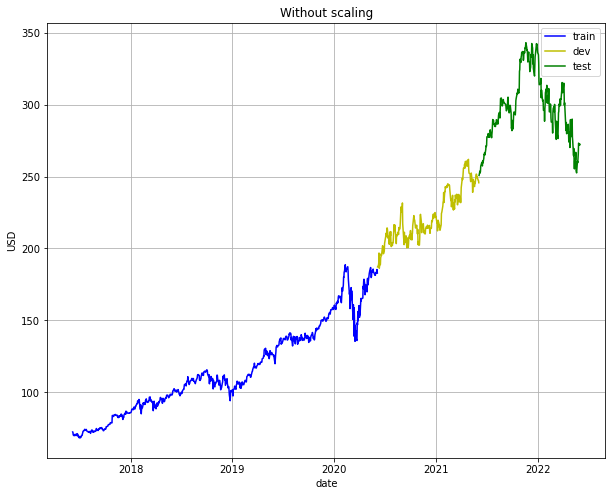

In [57]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title("Without scaling")

Text(0.5, 1.0, 'With scaling')

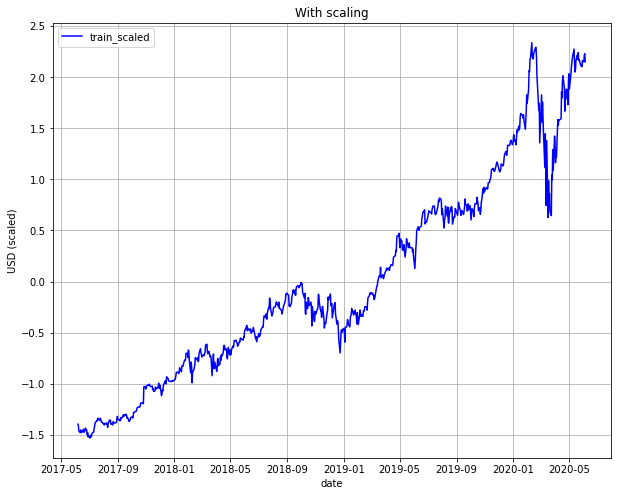

In [58]:
# Plot close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train_scaled.plot(x='date', y='close', style='b-', grid=True)
ax.legend(['train_scaled'])
ax.set_xlabel("date")
ax.set_ylabel("USD (scaled)")
ax.set_title("With scaling")

In [59]:
# Create the model

def train_pred_model(X_train_scaled, \
                    y_train_scaled, \
                    n_estimators=100, \
                    max_depth=3, \
                    learning_rate=0.1, \
                    min_child_weight=1, \
                    subsample=1, \
                    colsample_bytree=1, \
                    colsample_bylevel=1,
                    gamma=0):
                    
 model = XGBRegressor(seed=model_seed,
                     n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     min_child_weight=min_child_weight,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree,
                     colsample_bylevel=colsample_bylevel,
                     gamma=gamma)


In [60]:
# Train the regressor
model.fit(X_train_scaled, y_train_scaled)

NameError: name 'model' is not defined

In [ ]:
#Do prediction on train set

est_scaled = model.predict(X_train_scaled)
est = est_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

# Calculate RMSE
print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(y_train, est)))

# Calculate MAPE
print("MAPE on train set = %0.3f%%" % get_mape(y_train, est))

RMSE on train set = 1.286
MAPE on train set = 0.762%


Predictions on Training Data

Text(0.5, 1.0, 'Without scaling')

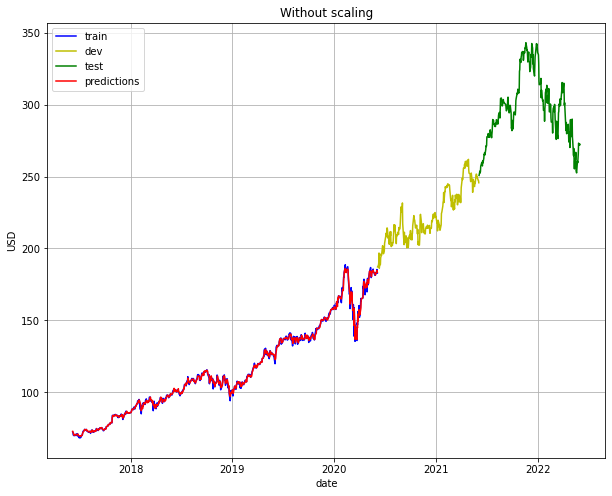

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'date': train['date']})

ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title('Without scaling')

Predictions of RSME and MAPE on dev Set

In [ ]:
# Do prediction on test set
est_scaled = model.predict(X_cv_scaled)
cv['est_scaled'] = est_scaled
cv['est'] = cv['est_scaled'] * cv['close_std'] + cv['close_mean']

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, cv['est']))
print("RMSE on dev set = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_bef_tuning = get_mape(y_cv, cv['est'])
print("MAPE on dev set = %0.3f%%" % mape_bef_tuning)

RMSE on dev set = 3.947
MAPE on dev set = 1.358%


C:\Users\tempe\AppData\Local\Temp\ipykernel_55996\3555681643.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv['est_scaled'] = est_scaled
C:\Users\tempe\AppData\Local\Temp\ipykernel_55996\3555681643.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv['est'] = cv['est_scaled'] * cv['close_std'] + cv['close_mean']


Text(0, 0.5, 'USD')

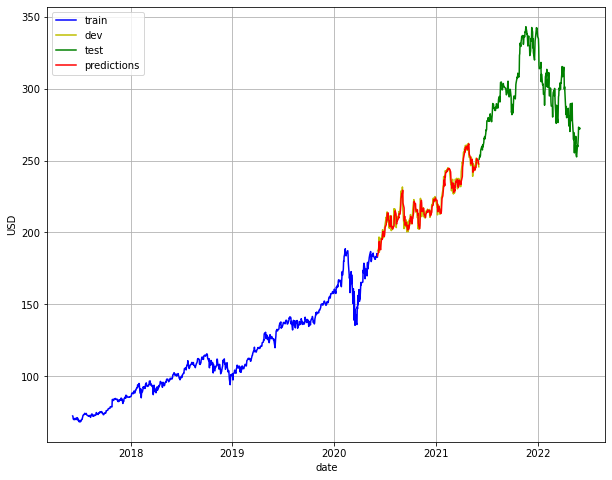

In [ ]:
# Plot prediction on dev set from the close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': cv['est'], 
                       'y_cv': y_cv,
                       'date': cv['date']})

ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to dev set')

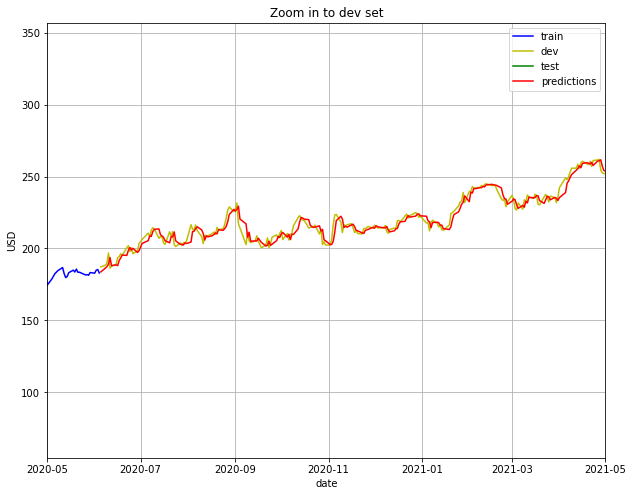

In [ ]:
# Plot adjusted close over time, for dev set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2020, 5, 1), date(2021, 5, 1)])
ax.set_title("Zoom in to dev set")

In [ ]:
# View a list of the features and their importance scores
imp = list(zip(train[features], model.feature_importances_))
imp.sort(key=lambda tup: tup[1]) 
imp[-10:]

[('range_oc_lag_1', 0.00020717495),
 ('range_hl_lag_2', 0.0002527424),
 ('range_oc_lag_2', 0.0002775735),
 ('range_hl_lag_3', 0.00038172962),
 ('close_lag_2', 0.039468043),
 ('vwap_lag_2', 0.12470698),
 ('close_lag_1', 0.13888706),
 ('close_lag_3', 0.14674126),
 ('vwap_lag_1', 0.24969909),
 ('vwap_lag_3', 0.29904515)]

In [ ]:
param_label = 'n_estimators'
param_list = range(10, 310, 10)

param2_label = 'max_depth'
param2_list = [2, 3, 4, 5, 6, 7, 8, 9]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
#tic =time()
for param in tqdm_notebook(param_list):
     #print("param = " + str(param))

    for param2 in param2_list:
        rmse, mape, _ = train_pred_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['close_mean'],
                                     cv['close_std'],
                                     seed=model_seed,
                                     n_estimators=param
                                     max_depth=param2, 
                                     learning_rate=learning_rate, 
                                     min_child_weight=min_child_weight, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma) 
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
#toc = time()
#print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   


C:\Users\tempe\AppData\Local\Temp\ipykernel_55996\1554280531.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(param_list):


  0%|          | 0/30 [00:00<?, ?it/s]

TypeError: train_pred_model() got multiple values for argument 'max_depth'

In [ ]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
n_estimators_opt, max_depth_opt

In [ ]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['n_estimators'].values[0], temp['max_depth'].values[0]

Tuning XGBoost: learning_rate(default=0.1) and min_child_weight(default=1)

In [ ]:
param_label = 'learning_rate'
param_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]

param2_label = 'min_child_weight'
param2_list = range(5, 21, 1)

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
#tic = time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))

    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=param, 
                                     min_child_weight=param2, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
        
error_rate = pd.DataFrame(error_rate)
#toc = time()
#print("Minutes taken = " + str((toc-tic)/60.0))
error_rate

In [ ]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [ ]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
learning_rate_opt = temp['learning_rate'].values[0]
min_child_weight_opt = temp['min_child_weight'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
learning_rate_opt, min_child_weight_opt

In [ ]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['learning_rate'].values[0], temp['min_child_weight'].values[0]

In [ ]:
param_label = 'subsample'
param_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'gamma'
param2_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
#tic = time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=param, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=param2)
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
#toc = time()
#print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

In [ ]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure


In [ ]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
subsample_opt = temp['subsample'].values[0]
gamma_opt = temp['gamma'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
subsample_opt, gamma_opt

In [ ]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['subsample'].values[0], temp['gamma'].values[0]

In [ ]:
param_label = 'colsample_bytree'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
#tic = time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))

  for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=subsample_opt, 
                                     colsample_bytree=param, 
                                     colsample_bylevel=param2, 
                                     gamma=gamma_opt)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
#toc = time()
#print("Minutes taken = " + str((toc-tic)/60.0))
error_rate

In [ ]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [ ]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
colsample_bytree_opt = temp['colsample_bytree'].values[0]
colsample_bylevel_opt = temp['colsample_bylevel'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
colsample_bytree_opt, colsample_bylevel_opt

In [ ]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['colsample_bytree'].values[0], temp['colsample_bylevel'].values[0]

In [ ]:
d = {'param': ['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 'subsample', 'colsample_bytree', 'colsample_bylevel', 'gamma', 'rmse', 'mape_pct'],
     'original': [n_estimators, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree, colsample_bylevel, gamma, rmse_bef_tuning, mape_bef_tuning],
     'after_tuning': [n_estimators_opt, max_depth_opt, learning_rate_opt, min_child_weight_opt, subsample_opt, colsample_bytree_opt, colsample_bylevel_opt, gamma_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params = tuned_params.round(3)
tuned_params

In [ ]:
rmse, mape, est = train_pred_eval_model(X_train_cv_scaled, 
                             y_train_cv_scaled, 
                             X_sample_scaled, 
                             y_sample, 
                             test['adj_close_mean'],
                             test['adj_close_std'],
                             seed=model_seed,
                             n_estimators=n_estimators_opt, 
                             max_depth=max_depth_opt, 
                             learning_rate=learning_rate_opt, 
                             min_child_weight=min_child_weight_opt, 
                             subsample=subsample_opt, 
                             colsample_bytree=colsample_bytree_opt, 
                             colsample_bylevel=colsample_bylevel_opt, 
                             gamma=gamma_opt)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'y_sample': y_sample,
                       'date': test['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [ ]:
# Plot adjusted close over time, for test set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018, 4, 1), date(2018, 11, 30)])
#ax.set_ylim([130, 155])
ax.set_title("Zoom in to test set")

In [ ]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='adj_close', style='gx-', grid=True)
ax = est_df.plot(x='date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using xgboost'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018, 4, 23), date(2018, 11, 23)])
#ax.set_ylim([130, 155])